In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the dataset
nrows = 3000000
data = pd.read_csv('/Users/harshvardhan/Downloads/US_Accidents_March23.csv', nrows=nrows)

# Preprocessing: Handle missing values
data['End_Lat'] = data['End_Lat'].fillna(data['Start_Lat'])
data['End_Lng'] = data['End_Lng'].fillna(data['Start_Lng'])
data['Wind_Chill(F)'] = data['Wind_Chill(F)'].fillna(data['Temperature(F)'])
data['Precipitation(in)'] = data['Precipitation(in)'].fillna(0)

# Feature Engineering: Create average coordinates
data['Accident_Lat'] = (data['Start_Lat'] + data['End_Lat']) / 2
data['Accident_Lng'] = (data['Start_Lng'] + data['End_Lng']) / 2

# Encode categorical variables
categorical_cols = [
    'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 
    'Nautical_Twilight', 'Astronomical_Twilight', 'Wind_Direction',
    'City', 'County', 'State', 'Timezone'
]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Select features and target
features = [
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
    'Wind_Speed(mph)', 'Precipitation(in)', 'Accident_Lat', 'Accident_Lng',
    'Traffic_Signal', 'Junction', 'Crossing', 'Weather_Condition',
    'Amenity', 'Bump', 'Stop', 'Railway', 'Roundabout', 'Station',
    'No_Exit', 'Traffic_Calming', 'Wind_Direction', 'Distance(mi)',
    'City', 'County', 'State', 'Timezone'
]
target = 'Severity'

X = data[features]
y = data[target]

# Handle missing values for features
num_imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(num_imputer.fit_transform(X), columns=features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Selected Features: ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Wind_Speed(mph)', 'Accident_Lat', 'Accident_Lng', 'Traffic_Signal', 'Junction', 'Crossing', 'Weather_Condition', 'Stop', 'Station', 'Distance(mi)', 'State', 'Timezone']
Cross-Validation Accuracy Scores: [0.6672125  0.667275   0.66765625 0.667725   0.66711667]
Mean Cross-Validation Accuracy: 0.67
Standard Deviation of Accuracy: 0.00
Logistic Regression with RFE Results:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7787
           2       0.68      0.92      0.79    390500
           3       0.55      0.20      0.29    198939
           4       0.15      0.01      0.02      2774

    accuracy                           0.67    600000
   macro avg       0.35      0.28      0.27    600000
weighted avg       0.63      0.67      0.61    600000

              Feature  Ranking
0      Temperature(F)        1
21       Distance(mi)        1
17            Station        1

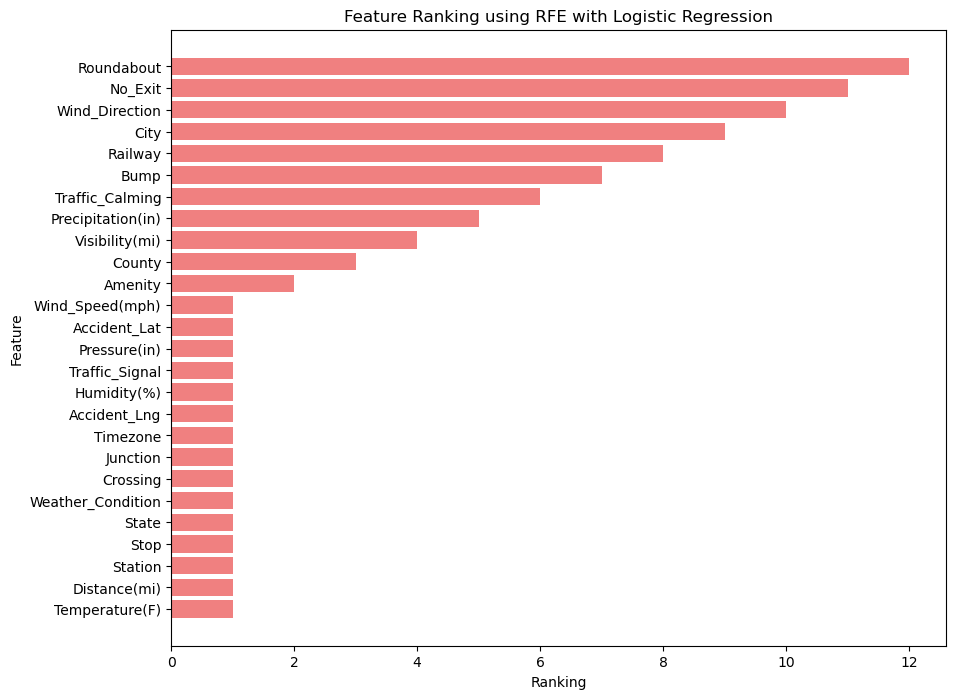

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Logistic Regression with RFE
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(log_reg, n_features_to_select=15)  # Select top 15 features
rfe.fit(X_train, y_train)

# Selected Features
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print("Selected Features:", selected_features)

# Transform Data with Selected Features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Cross-Validation Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_train_rfe, y_train, cv=cv, scoring='accuracy')  # Evaluate accuracy
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of Accuracy: {cv_scores.std():.2f}")

# Fit Logistic Regression with Selected Features
log_reg.fit(X_train_rfe, y_train)

# Predictions and Evaluation
y_pred_log = log_reg.predict(X_test_rfe)
print("Logistic Regression with RFE Results:")
print(classification_report(y_test, y_pred_log))

# Visualize Feature Ranking
rfe_ranking = pd.DataFrame({'Feature': features, 'Ranking': rfe.ranking_}).sort_values(by='Ranking')
print(rfe_ranking)

plt.figure(figsize=(10, 8))
plt.barh(rfe_ranking['Feature'], rfe_ranking['Ranking'], color='lightcoral')
plt.xlabel('Ranking')
plt.ylabel('Feature')
plt.title('Feature Ranking using RFE with Logistic Regression')
plt.show()


Cross-Validation Accuracy Scores: [0.85654167 0.85639583 0.85655208 0.85746875 0.8572125 ]
Mean Cross-Validation Accuracy: 0.86
Standard Deviation of Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.04      0.08      7787
           2       0.89      0.91      0.90    390500
           3       0.81      0.82      0.81    198939
           4       0.55      0.13      0.20      2774

    accuracy                           0.86    600000
   macro avg       0.73      0.47      0.50    600000
weighted avg       0.86      0.86      0.86    600000

              Feature  Importance
6        Accident_Lat    0.178537
7        Accident_Lng    0.177892
2        Pressure(in)    0.074548
0      Temperature(F)    0.066248
22               City    0.065960
1         Humidity(%)    0.063218
23             County    0.058070
8      Traffic_Signal    0.052858
4     Wind_Speed(mph)    0.044287
20     Wind_Direction    0.043386
24 

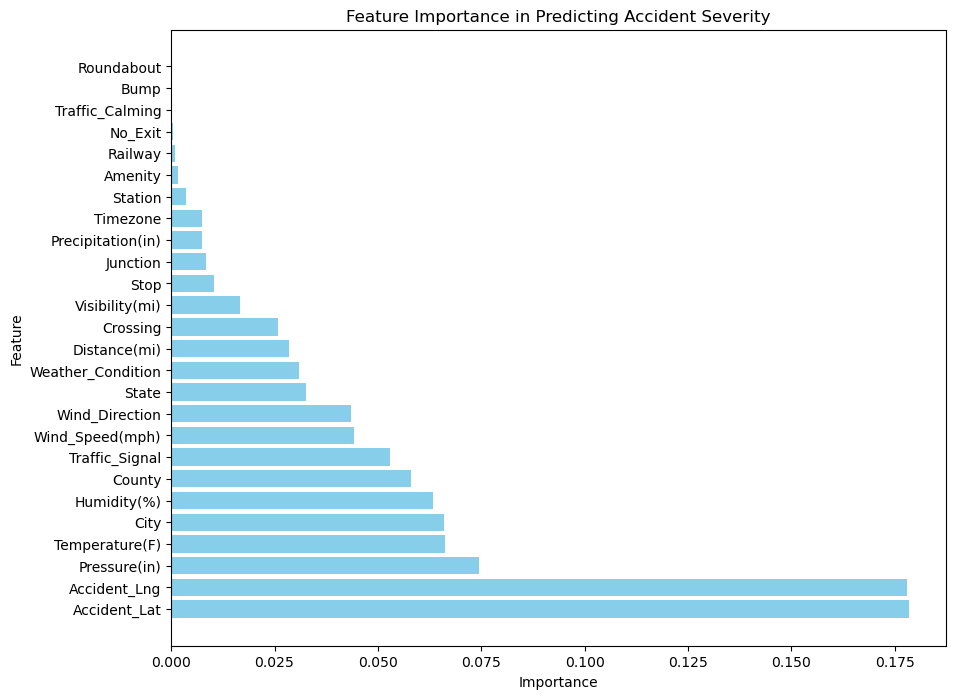

In [12]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Model: Random Forest
rf = RandomForestClassifier(random_state=42)

# Cross-Validation Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Use stratified splits to maintain class balance
cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')  # Evaluate accuracy
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of Accuracy: {cv_scores.std():.2f}")

# Train Final Model on Full Training Set
rf.fit(X_train, y_train)

# Evaluate Model
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Accident Severity')
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Model: Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Cross-Validation Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Use stratified splits to maintain class balance
cv_scores = cross_val_score(dt, X_train, y_train, cv=cv, scoring='accuracy')  # Evaluate accuracy
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of Accuracy: {cv_scores.std():.2f}")

# Train Final Model on Full Training Set
dt.fit(X_train, y_train)

# Evaluate Model
y_pred = dt.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = dt.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print(feature_importances)

# Visualize Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Predicting Accident Severity')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a heatmap of accident locations
plt.figure(figsize=(12, 8))

sns.kdeplot(
    x=data['Accident_Lng'],
    y=data['Accident_Lat'],
    cmap="Reds",
    fill=True,
    bw_adjust=0.5,  # Decrease bandwidth for finer granularity
    thresh=0.01  # Show more low-density regions
)

plt.title('Heatmap of Accident High-Risk Areas in the US')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
